In [5]:
import numpy as np
import healpy as hp
import math
import matplotlib.pyplot as plt

%matplotlib inline

from astropy.io import fits
from statistics import mean
from scipy.optimize import curve_fit
from astropy_healpix import HEALPix
from tqdm import tqdm
from scipy.optimize import fsolve

# HEALPY Math (Unimportant) vvv

MATH\
$n=\sqrt{\frac{len(array)}{12}}$\
l=total length of chain= $2n+1$ [(4,8,12,16,16,16,16,16,16,16,16,16,12,8,4); l=9]\
N=total number of rows=(4n-1) [above,n=4,#rows=15]\
S=total sum=$12n^2$\
lt=thickness of each row in degrees=180/N (above, N=15, lt=180/15=12)\
s=number of rows from lat=0= ROUND UP: s=desired region cut out/lt\
index=$len(array)-(2n(n-1)+4n(n-s))$\ <-- iff s<=n\
th=thickness=(2s+1)*(4n)

Real stuff vvv

# Data

fornengo files

"lambda_DRAO_22MHz_1_256.fits",22,"G",False\
"MAIPU_MU_1_64.fits",45,"G",False\
"haslam408_dsds_Remazeilles2014.fits",408,"G",False\
"Dwingeloo_Kelvins_1_256.fits",820,"G",False\
"STOCKERT+VILLA-ELISA_1420MHz_1_256.fits",1420,"G",False\
"lambda_23de_hea.fits",2326,"C",False\

LWA files

"LWA Files/healpix-all-sky-rav-wsclean-map-35.fits",35,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-38.fits",38,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-40.fits",40,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-45.fits",45,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-50.fits",50,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-60.fits",60,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-70.fits",70,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-74.fits",74,"C",False\
"LWA Files/healpix-all-sky-rav-wsclean-map-80.fits",80,"C",False\

ARCADE files

"ARCADE Files/arc2_3150_v19.fits",3150,"G",True\
"ARCADE Files/arc2_3410_v19.fits",3410,"G",True\
"ARCADE Files/arc2_8330_v19.fits",8330,"G",True\
"ARCADE Files/arc2_9720_v19.fits",9720,"G",True\
"ARCADE Files/arc2_10490_v19.fits",10490,"G",True\
See pg 2 as to why we dont include vvv\
"ARCADE Files/arc2_7970_v19.fits",7970,"G",True\
"ARCADE Files/arc2_29500_v19.fits",29500,"G",True\
"ARCADE Files/arc2_31000_v19.fits",31000,"G",True\
"ARCADE Files/arc2_88200_v19.fits",88200,"G",True\
"ARCADE Files/arc2_89800_v19.fits",89800,"G",True\

In [130]:
files=[["lambda_DRAO_22MHz_1_256.fits",22,"G",False,None],
       ["LWA Files/healpix-all-sky-rav-wsclean-map-35.fits",35,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-35.fits"],
       ["LWA Files/healpix-all-sky-rav-wsclean-map-38.fits",38,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-38.fits"],
       ["LWA Files/healpix-all-sky-rav-wsclean-map-40.fits",40,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-40.fits"],
       ["LWA Files/healpix-all-sky-rav-wsclean-map-45.fits",45,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-45.fits"],
       ["MAIPU_MU_1_64.fits",45,"G",False,None],
       ["LWA Files/healpix-all-sky-rav-wsclean-map-50.fits",50,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-50.fits"],
       ["LWA Files/healpix-all-sky-rav-wsclean-map-60.fits",60,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-60.fits"],
       ["LWA Files/healpix-all-sky-rav-wsclean-map-70.fits",70,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-70.fits"],
       ["LWA Files/healpix-all-sky-rav-wsclean-map-74.fits",74,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-74.fits"],
       ["LWA Files/healpix-all-sky-rav-wsclean-map-80.fits",80,"C",False,"LWA Uncertainties/healpix-all-sky-rav-wsclean-err-80.fits"],
       ["haslam408_dsds_Remazeilles2014.fits",408,"G",False,None],
       ["Dwingeloo_Kelvins_1_256.fits",820,"G",False,None],
       ["STOCKERT+VILLA-ELISA_1420MHz_1_256.fits",1420,"G",False,None],
       ["lambda_23de_hea.fits",2326,"C",False,None],
       ["ARCADE Files/arc2_3150_v19.fits",3150,"G",True,None],
       ["ARCADE Files/arc2_3410_v19.fits",3410,"G",True,None],
       #["ARCADE Files/arc2_7970_v19.fits",7970,"G",True,None],
       ["ARCADE Files/arc2_8330_v19.fits",8330,"G",True,None],
       ["ARCADE Files/arc2_9720_v19.fits",9720,"G",True,None],
       ["ARCADE Files/arc2_10490_v19.fits",10490,"G",True,None],
       #["ARCADE Files/arc2_29500_v19.fits",29500,"G",True,None],
       #["ARCADE Files/arc2_31000_v19.fits",31000,"G",True,None],
       #["ARCADE Files/arc2_88200_v19.fits",88200,"G",True,None],
       #["ARCADE Files/arc2_89800_v19.fits",89800,"G",True,None]
      ]

# files[i][0]=file name
# files[i][1]=Mhz
# files[i][2]=coords
# files[i][3]=In thermal temp?
# files[i][4]=Uncertainty map, if there is one (WIP)

In [131]:
def convert_to_TA(array,freq): #This function converts thermal temp to antenna temp using the standard TA=T*x/(e^x-1) formula
    for x in range(len(array)):
        if not array[x]<=0 or array[x]==np.inf:
            IGL=(6.62607015*(10**(-34))*freq*10**6)/(1.380649*(10**(-23))*array[x])
            array[x]=(IGL/(np.exp(IGL)-1))*array[x]

In [132]:
def convert_to_TT(temp_array,freq_array): #This function does the opposite, and converts to thermal temp
    TT_list=[]
    for i in range(len(temp_array)):
        TA=temp_array[i]
        freq=freq_array[i]
        convert_to_thermal_temp = lambda TT : TA-((6.62607015*(10**(-34))*freq*10**6)/(1.380649*(10**(-23))*TT)/
                       (np.exp((6.62607015*(10**(-34))*freq*10**6)/(1.380649*(10**(-23))*TT))-1))*TT 
        TT_guess = TA
        TT = fsolve(convert_to_thermal_temp, TT_guess)
        TT_list.append(TT[0])
    return TT_list

# Method Used by Arcade to find $T_{G}$:
- Not many data points, pole data is clumped together

In [163]:
def cscb_Temp_fit_ARCADE(file,region):
    #We first convert the array to a list to go faster
    if file[1]==1420:#1420 MHz is the only one on this list (so far) that is in mK
        File_as_List=(hp.read_map(file[0])/1000).tolist()
    else:
        File_as_List=(hp.read_map(file[0])).tolist()
    
    #If we start in thermo-temp, we make sure to converto to antenna temp:
    if file[3]==True:
        convert_to_TA(File_as_List,file[1])
        
    #If we have the uncertainty map, we read it and convert it to a list
    if not file[4]==None:
        Unc_as_List=(hp.read_map(file[4])).tolist()
    
    #Next, we define our theta coords to bin each value by csc|b|, making sure to go to galactic coords
    npix=int(np.sqrt(len(File_as_List)/12)) #12*Nside^2=total number of pixels
    theta1,phi1=hp.pix2ang(npix,np.arange(len(File_as_List)))
    if file[2]=="E":
        r = hp.rotator.Rotator(coord=['E','G'])
        theta=np.degrees(r(theta1,phi1)[0])
    if file[2]=="C":
        r = hp.rotator.Rotator(coord=['C','G'])
        theta=np.degrees(r(theta1,phi1)[0])
    if file[2]=="G":
        theta=np.degrees(theta1)
    
    cscb_Temp_values=[[],[],[],[],[],[],[],[],[],[]] #each entry represents an 0.5 increase from 1.25 (1.25,1.75,2.25...)
    unc_Temp_values=[[],[],[],[],[],[],[],[],[],[]]
    #Now, we bin each actual temp (AKA, not inf, negative, or NaN) and its corresponding theta (b or latitude) by csc|b|
    for x in tqdm(range(int(len(File_as_List)))):
        if File_as_List[x]>0 and math.isnan(File_as_List[x])==False: #ignore hp.UNSEEN and 0 temp pixels
            #We then may choose to look at the Northern hemisphere, the Southern one, or both.
            if region=="North" or region=="All":
                if 90-theta[x]>10: # We ignore the galactic center: 10>|b|
                    range_csc=0 #dummy var to index cscb_Temp_values
                    csc=1/np.sin(abs(np.radians(90-theta[x])))
                    while range_csc<=9 and abs(90-theta[x])>10:
                        if range_csc/2+1<csc<range_csc/2+1.5: #append all values within 0.25 csc |b|
                            cscb_Temp_values[range_csc].append(File_as_List[x])
                            if not file[4]==None:
                                unc_Temp_values[range_csc].append(Unc_as_List[x])
                            range_csc=range_csc+10
                        else:
                            range_csc=range_csc+1 #if the entry is not within 1<x<1.5, increase to 1.5<x<2.0 (for 1.75), etc.
            if region=="South" or region=="All":
                if 90-theta[x]<-10:
                    range_csc=0
                    desired_csc=1/np.sin(abs(np.radians(90-theta[x])))
                    while range_csc<=9 and abs(90-theta[x])>10:
                        if range_csc/2+1<desired_csc<range_csc/2+1.5: #append all values within 0.25 csc |b|
                            test=File_as_List[x]
                            cscb_Temp_values[range_csc].append(test)
                            if not file[4]==None:
                                unc_Temp_values[range_csc].append(Unc_as_List[x])
                            range_csc=range_csc+10
                            break
                        else:
                            range_csc=range_csc+1 #if the entry is not within 1<x<1.5, increase to 1.5<x<2.0 (for 1.75), etc.
    
    #Finally, we make our plots
    Mean_cscb_Temp=[]
    Mean_unc_vals=[]
    freq_list=[]
    freq_dummy=0.75
    for i in range(10):
        freq_dummy=freq_dummy+0.5
        if not cscb_Temp_values[i]==[]: #if there are any values within the range of csc we defined above:
            Mean_cscb_Temp.append(mean(cscb_Temp_values[i])) # we mean the temperature and create a scatter plot
            if not file[4]==None:
                #For uncertainty, we mean the uncertainties, and take one std of the values.
                Mean_unc_vals.append(mean(unc_Temp_values[i])+np.std(unc_Temp_values[i]))
            freq_list.append(freq_dummy)
    Mean_cscb_Temp = np.array(Mean_cscb_Temp)
    #Plotting uncertainty:
    if not file[4]==None:
        plt.fill_between(freq_list, Mean_cscb_Temp-Mean_unc_vals, Mean_cscb_Temp+Mean_unc_vals,facecolor="pink")
    #Plotting the scatter:
    plt.scatter(freq_list,Mean_cscb_Temp,color="red")
    #Fitting the scatter and plotting:
    a, b = np.polyfit(freq_list,Mean_cscb_Temp, 1) #fit the data
    plt.plot(freq_list,a*np.array(freq_list)+b)
    plt.title("csc|b| vs Temp at %s MHz" % file[1])
    plt.xlabel("csc|b|")
    plt.ylabel("Antenna Temp (K)")
    plt.grid()
    plt.show()
    #From the given equation, TA=c+T_g*csc|b| therefore, T_g=a, c=b
    T_g=a
    c=b
    print("T_extra at %sMHz is %.5f" % (file[1], c))
    print("T_g at %sMHz is %.5f"% (file[1],T_g))
    #Finally we append the values of T_g, c, and freq to make our second scatter plot below
    c_array_ARCADE.append(c)
    freq_ARCADE.append(file[1])
    Temp_ARCADE.append(T_g)


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:03<00:00, 200484.25it/s]


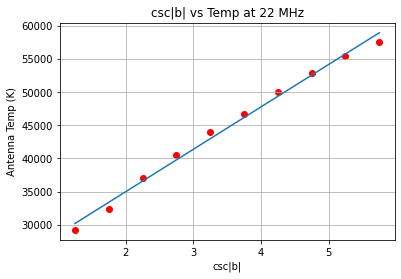

T_extra at 22MHz is 22192.76451
T_g at 22MHz is 6397.06613


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:03<00:00, 225329.43it/s]


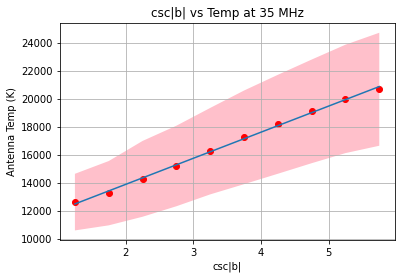

T_extra at 35MHz is 10158.00460
T_g at 35MHz is 1866.86899


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:03<00:00, 234395.03it/s]


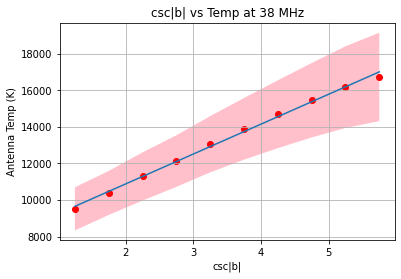

T_extra at 38MHz is 7608.87055
T_g at 38MHz is 1635.03062


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:03<00:00, 244098.17it/s]


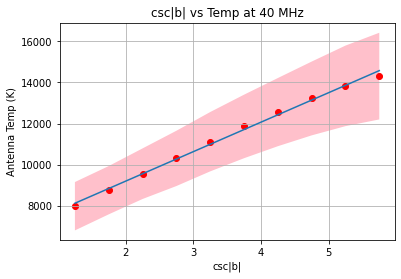

T_extra at 40MHz is 6346.94693
T_g at 40MHz is 1430.76426


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:03<00:00, 251597.28it/s]


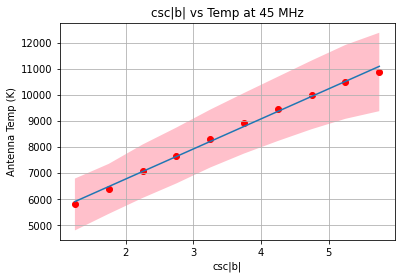

T_extra at 45MHz is 4475.12382
T_g at 45MHz is 1149.95596


100%|█████████████████████████████████████████████████████████████████████████| 49152/49152 [00:00<00:00, 221675.73it/s]


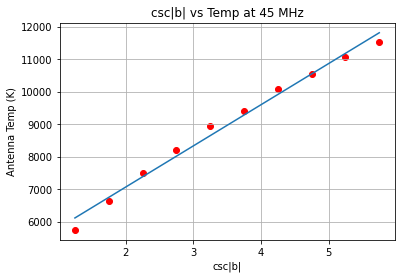

T_extra at 45MHz is 4535.83496
T_g at 45MHz is 1267.01784


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:03<00:00, 251425.60it/s]


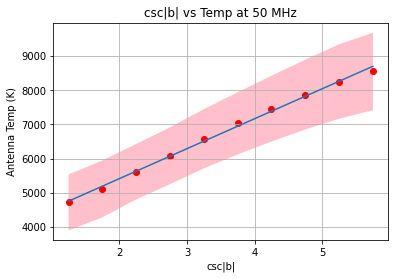

T_extra at 50MHz is 3657.97303
T_g at 50MHz is 876.87884


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:03<00:00, 248741.48it/s]


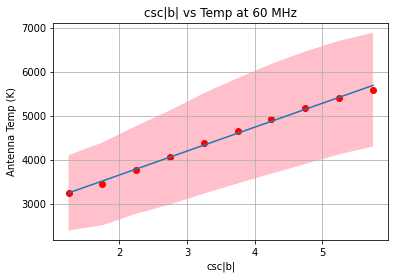

T_extra at 60MHz is 2565.41587
T_g at 60MHz is 543.24759


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:03<00:00, 255427.90it/s]


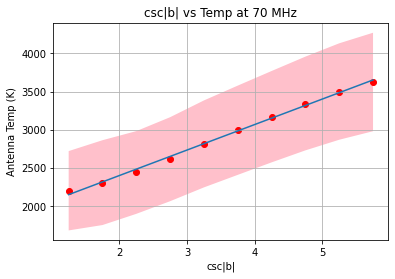

T_extra at 70MHz is 1737.85686
T_g at 70MHz is 332.79542


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:03<00:00, 254363.41it/s]


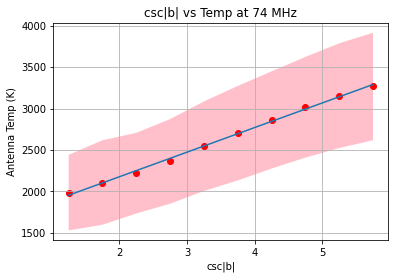

T_extra at 74MHz is 1582.85569
T_g at 74MHz is 296.89018


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:03<00:00, 249846.15it/s]


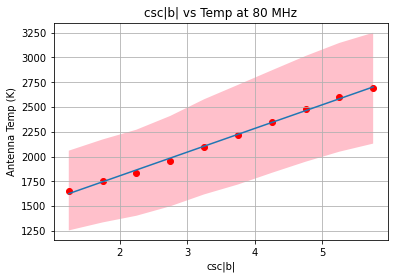

T_extra at 80MHz is 1326.83232
T_g at 80MHz is 239.29052


100%|█████████████████████████████████████████████████████████████████████| 3145728/3145728 [00:14<00:00, 214105.68it/s]


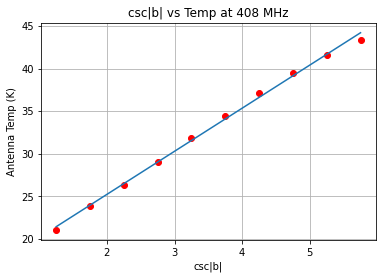

T_extra at 408MHz is 15.09760
T_g at 408MHz is 5.06230


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 363654.32it/s]


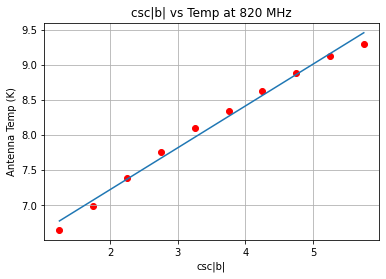

T_extra at 820MHz is 6.03208
T_g at 820MHz is 0.59538


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:03<00:00, 200008.28it/s]


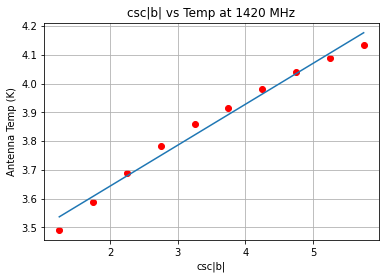

T_extra at 1420MHz is 3.35842
T_g at 1420MHz is 0.14230


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 355902.49it/s]


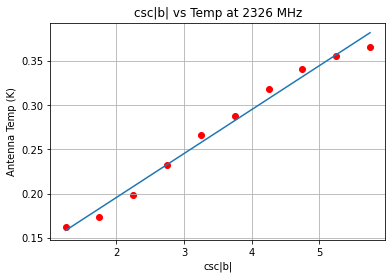

T_extra at 2326MHz is 0.09612
T_g at 2326MHz is 0.04971


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1558783.19it/s]


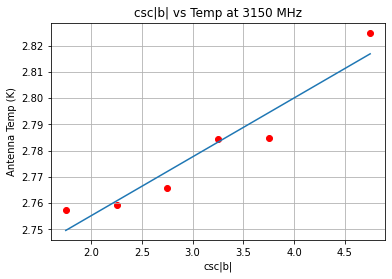

T_extra at 3150MHz is 2.71028
T_g at 3150MHz is 0.02244


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1130948.99it/s]


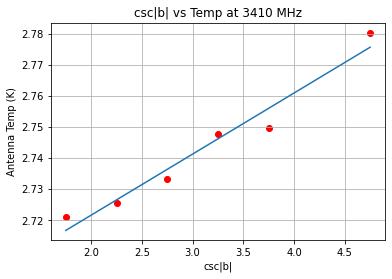

T_extra at 3410MHz is 2.68235
T_g at 3410MHz is 0.01964


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1375563.35it/s]


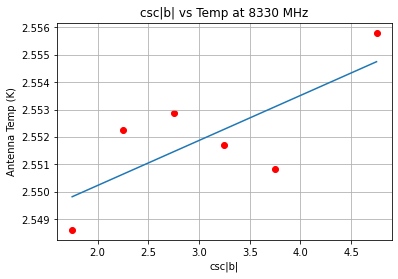

T_extra at 8330MHz is 2.54695
T_g at 8330MHz is 0.00164


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1118675.28it/s]


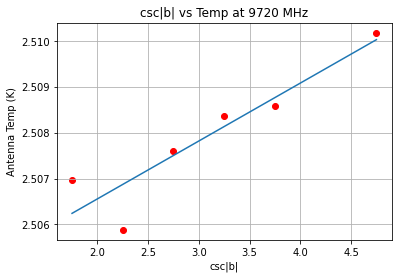

T_extra at 9720MHz is 2.50403
T_g at 9720MHz is 0.00126


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1429590.80it/s]


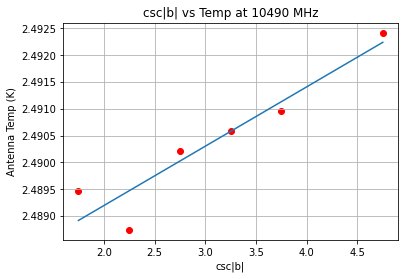

T_extra at 10490MHz is 2.48698
T_g at 10490MHz is 0.00111


In [180]:
c_array_ARCADE=[]
freq_ARCADE=[]
Temp_ARCADE=[]
Region="All"
for file in files:
    cscb_Temp_fit_ARCADE(file,Region)

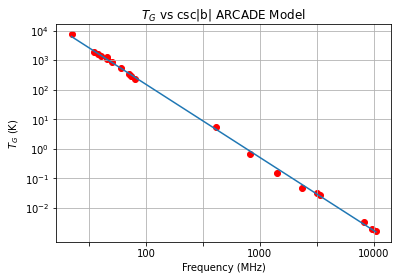

Beta=-2.4684 T_gal=7.1155


In [162]:
#Log and fit
FreqFit = np.log10(freq_ARCADE)
TempFit = np.log10(np.array(Temp_ARCADE))
a, b = np.polyfit(FreqFit,TempFit, 1)
plt.plot(FreqFit,a*FreqFit+b)
plt.grid()
plt.scatter(np.log10(freq_ARCADE),np.log10(Temp_ARCADE),color="red")
plt.yticks([-2,-1,0,1,2,3,4],["$10^{-2}$","$10^{-1}$","$10^0$","$10^1$","$10^2$","$10^3$","$10^4$"])
plt.xticks([1.5,2,2.5,3,3.5,4],["","100","","1000","","10000"])
plt.xlabel("Frequency (MHz)")
plt.ylabel("$T_G$ (K)")
plt.title("$T_G$ vs csc|b| ARCADE Model")
plt.show()
print("Beta=%.4f"%a,"T_gal=%.4f"%b)

# Holistic Method:
- Plots each Temp according to its own csc|b|, does not average and thus favors latitudes with more points (center)

In [168]:
def cscb_Temp_fit_hol(file,region):
    
    #We first convert the array to a list to go faster
    if file[1]==1420:#1420 MHz is the only one on this list (so far) that is in mK
        File_as_List=(hp.read_map(file[0])/1000).tolist()
    else:
        File_as_List=(hp.read_map(file[0])).tolist()
    #If we start in thermo-temp, we make sure to converto to antenna temp:
    
    if file[3]==True:
        convert_to_TA(File_as_List,file[1])
    #If we have an uncertainty map, we read it and make it a list
    if not file[4]==None:
        Unc_as_List=(hp.read_map(file[4])).tolist()
    
    #Next, we define our theta coords to bin each value by csc|b|, making sure to go to galactic coords
    npix=int(np.sqrt(len(File_as_List)/12)) #12*NPix^2=total number of pixels
    theta1,phi1=hp.pix2ang(npix,np.arange(len(File_as_List)))
    if file[2]=="E":
        r = hp.rotator.Rotator(coord=['E','G'])
        theta=np.degrees(r(theta1,phi1)[0])
        phi=np.degrees(r(theta1,phi1)[1])+180 #phi rotates oddly.
    if file[2]=="C":
        r = hp.rotator.Rotator(coord=['C','G'])
        theta=np.degrees(r(theta1,phi1)[0])
        phi=np.degrees(r(theta1,phi1)[1])+180
    if file[2]=="G":
        theta=np.degrees(theta1)
        phi=np.degrees(phi1)
    
    #Now we calculate csc|b| for each pixel and add it and its temperature to a list
    Tempvalues=[]
    cscvalues=[]
    uncvals=[]
    for x in tqdm(range(int(len(File_as_List)))):
        if File_as_List[x]>0 and math.isnan(File_as_List[x])==False: #ignore hp.UNSEEN and 0 pixels
            #Again, we may look at the northern hemisphere, southern, or both
            if region=="North" or region=="All":
                if 90-theta[x]>10:
                    Tempvalues.append(File_as_List[x])
                    csc=1/np.sin(np.radians(abs(90-theta[x])))
                    cscvalues.append(csc)
                    if not file[4]==None:
                        uncvals.append(Unc_as_List[x])
            if region=="South" or region=="All":
                if 90-theta[x]<-10:
                    Tempvalues.append(File_as_List[x])
                    csc=1/np.sin(np.radians(abs(90-theta[x])))
                    cscvalues.append(csc)  
                    if not file[4]==None:
                        uncvals.append(Unc_as_List[x])
#            if region=="Coldest": ---This was made for the coldest spot but it looks like they don't actually use this---
#                if file[2]=="G":
#                    if 48+15>(90-(theta[x]))>48-15 and 196+15>((phi[x]))>196-15:
#                        Tempvalues.append(File_as_List[x])
#                        csc=1/np.sin(np.radians(abs(90-theta[x])))
#                        cscvalues.append(csc)  
#                elif file[2]=="C" or file[2]=="E":
#                    if 48+15>(90-(theta[x]))>48-15 and 164+15>((phi[x]))>164-15:
#                        Tempvalues.append(File_as_List[x])
#                        csc=1/np.sin(np.radians(abs(90-theta[x])))
#                        cscvalues.append(csc) 
#                if not file[4]==None:
#                    uncvals.append(Unc_as_List[x])

#Now we plot!
    Tempvalues = np.array(Tempvalues)
    if not file[4]==None:
        #No need to worry about std, here as we aren't taking any kind of mean
        plt.fill_between(cscvalues, Tempvalues-uncvals, Tempvalues+uncvals,facecolor="pink")
    plt.scatter(cscvalues,Tempvalues,s=0.1,color="red")
    a, b = np.polyfit(cscvalues,Tempvalues, 1) #fit the data
    plt.plot(cscvalues,a*np.array(cscvalues)+b)
    plt.title("csc|b| vs Temp at %s MHz" % file[1])
    plt.xlabel("csc|b|")
    plt.ylabel("Antenna Temp (K)")
    plt.grid()
    plt.show()
    #From the given equation, TA=c+T_g*csc|b| therefore, T_g=a, c=b
    T_g=a
    c=b
    print("T_extra at %sMHz is %.5f" % (file[1], c))
    print("T_g at %sMHz is %.5f"% (file[1],T_g))
    #Finally we append the values of T_g, c, and freq to make our second scatter plot below
    c_array_hol.append(c)
    freq_hol.append(file[1])
    Temp_hol.append(T_g)

100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 434116.85it/s]


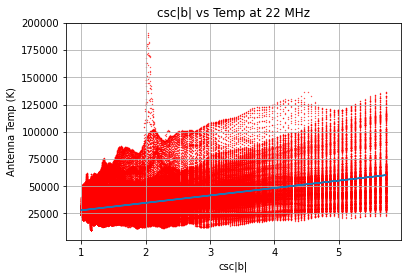

T_extra at 22MHz is 21049.24779
T_g at 22MHz is 6813.73412


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 371836.34it/s]


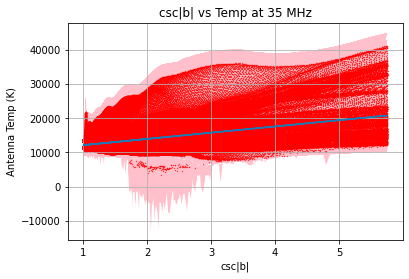

T_extra at 35MHz is 10313.21760
T_g at 35MHz is 1825.04680


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 356255.21it/s]


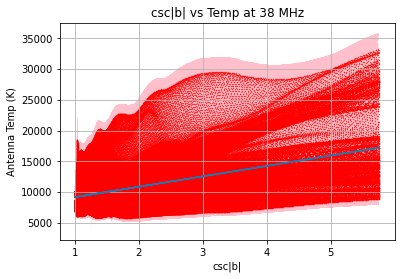

T_extra at 38MHz is 7478.07870
T_g at 38MHz is 1692.38443


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 328058.35it/s]


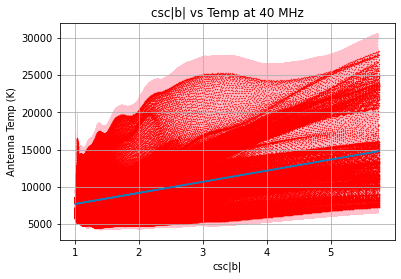

T_extra at 40MHz is 6206.98079
T_g at 40MHz is 1489.23721


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 359837.29it/s]


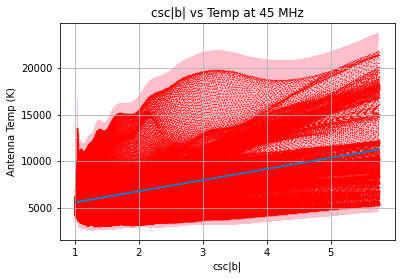

T_extra at 45MHz is 4362.71864
T_g at 45MHz is 1196.55769


100%|█████████████████████████████████████████████████████████████████████████| 49152/49152 [00:00<00:00, 313370.22it/s]


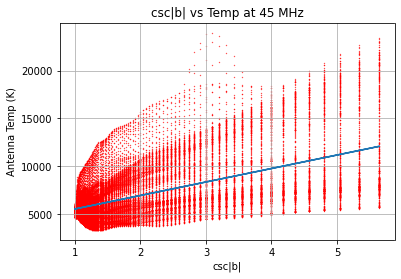

T_extra at 45MHz is 4145.98242
T_g at 45MHz is 1407.42233


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 372007.14it/s]


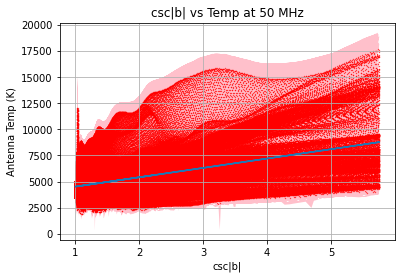

T_extra at 50MHz is 3618.00241
T_g at 50MHz is 896.47536


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 370719.99it/s]


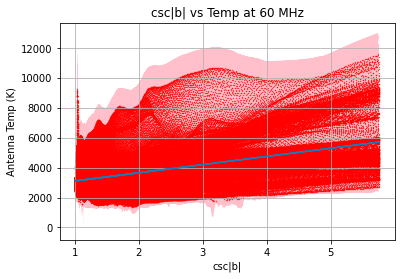

T_extra at 60MHz is 2561.75897
T_g at 60MHz is 548.25268


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 369990.79it/s]


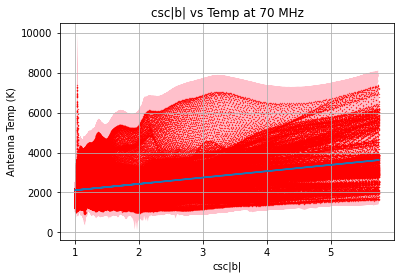

T_extra at 70MHz is 1789.79239
T_g at 70MHz is 318.19898


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 354397.12it/s]


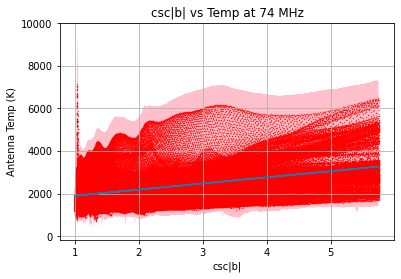

T_extra at 74MHz is 1618.15962
T_g at 74MHz is 287.89963


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 358337.95it/s]


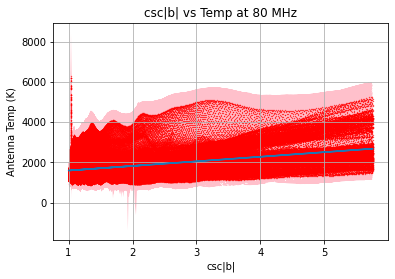

T_extra at 80MHz is 1365.15364
T_g at 80MHz is 228.49672


100%|█████████████████████████████████████████████████████████████████████| 3145728/3145728 [00:10<00:00, 311047.49it/s]


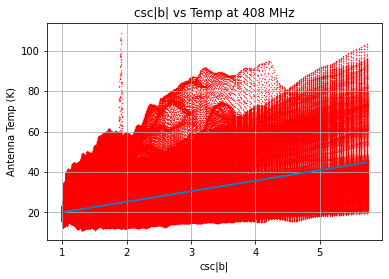

T_extra at 408MHz is 14.73072
T_g at 408MHz is 5.22415


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 524849.10it/s]


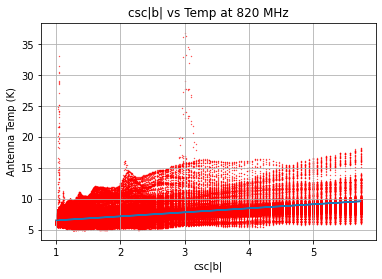

T_extra at 820MHz is 5.87435
T_g at 820MHz is 0.65276


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:02<00:00, 317151.42it/s]


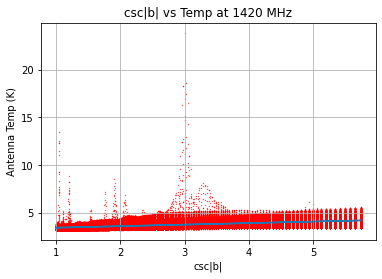

T_extra at 1420MHz is 3.30773
T_g at 1420MHz is 0.16021


100%|███████████████████████████████████████████████████████████████████████| 786432/786432 [00:01<00:00, 496734.61it/s]


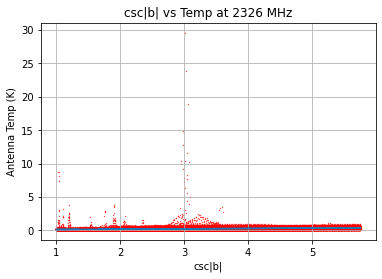

T_extra at 2326MHz is 0.09731
T_g at 2326MHz is 0.04961


100%|███████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 988636.68it/s]


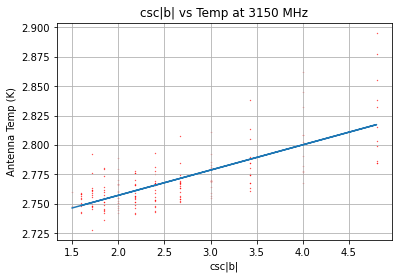

T_extra at 3150MHz is 2.71436
T_g at 3150MHz is 0.02146


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1873077.76it/s]


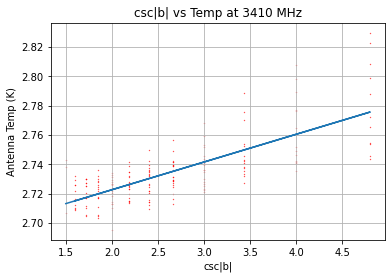

T_extra at 3410MHz is 2.68488
T_g at 3410MHz is 0.01891


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1923406.76it/s]


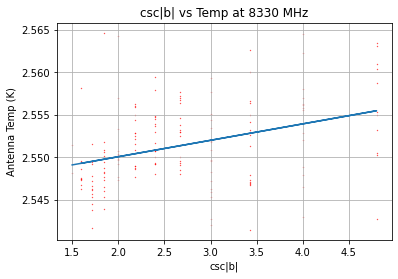

T_extra at 8330MHz is 2.54623
T_g at 8330MHz is 0.00193


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 1897629.14it/s]


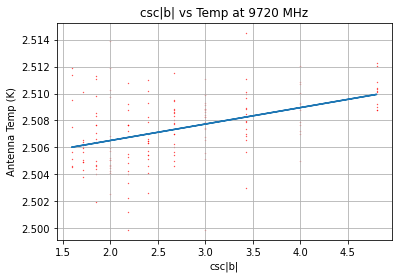

T_extra at 9720MHz is 2.50407
T_g at 9720MHz is 0.00122


100%|██████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 2091365.34it/s]


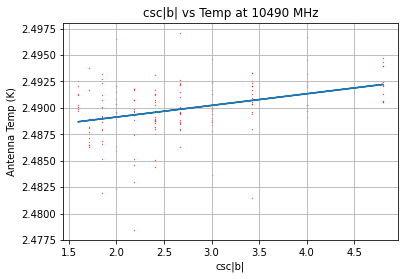

T_extra at 10490MHz is 2.48693
T_g at 10490MHz is 0.00110


In [169]:
c_array_hol=[]
freq_hol=[]
Temp_hol=[]
Region="All"
for file in files:
    cscb_Temp_fit_hol(file,Region)

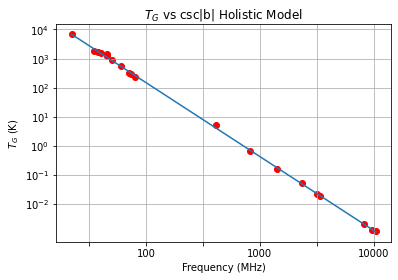

Beta=-2.5432 T_gal=7.2504


In [171]:
FreqFit = np.log10(freq_hol)
TempFit = np.log10(np.array(Temp_hol))
a, b = np.polyfit(FreqFit,TempFit, 1)
plt.plot(FreqFit,a*FreqFit+b)
plt.grid()
plt.scatter(np.log10(freq_hol),np.log10(Temp_hol),color="red")
plt.yticks([-2,-1,0,1,2,3,4],["$10^{-2}$","$10^{-1}$","$10^0$","$10^1$","$10^2$","$10^3$","$10^4$"])
plt.xticks([1.5,2,2.5,3,3.5,4],["","100","","1000","","10000"])
plt.xlabel("Frequency (MHz)")
plt.ylabel("$T_G$ (K)")
plt.title("$T_G$ vs csc|b| Holistic Model")
plt.show()
print("Beta=%.4f"%a,"T_gal=%.4f"%b)

# Holistic Mean Method
- bin by EACH UNIQUE (up to the hundredths) csc|b| value-- this means that csc|b| towards the poles, with few data points, are as equal as the central ones; top heavy

In [177]:
def cscb_Temp_fit_hol_mean(file,region):

    #We first convert the array to a list to go faster
    if file[1]==1420:#1420 MHz is the only one on this list (so far) that is in mK
        File_as_List=(hp.read_map(file[0])/1000).tolist()
    else:
        File_as_List=(hp.read_map(file[0])).tolist()
        
    #If we start in thermo-temp, we make sure to converto to antenna temp:
    if file[3]==True:
        convert_to_TA(File_as_List,file[1])
    
    #If the file has an uncertainty map, we read it, and turn it into a list
    if not file[4]==None:
        Unc_as_List=(hp.read_map(file[4])).tolist()
    
    #Next, we define our theta coords to bin each value by csc|b|, making sure to go to galactic
    npix=int(np.sqrt(len(File_as_List)/12)) #12*NPix^2=total number of pixels
    theta1,phi1=hp.pix2ang(npix,np.arange(len(File_as_List)))
    if file[2]=="E":
        r = hp.rotator.Rotator(coord=['E','G'])
        theta=np.degrees(r(theta1,phi1)[0])
        phi=np.degrees(r(theta1,phi1)[1])+180
    if file[2]=="C":
        r = hp.rotator.Rotator(coord=['C','G'])
        theta=np.degrees(r(theta1,phi1)[0])
        phi=np.degrees(r(theta1,phi1)[1])+180
    if file[2]=="G":
        theta=np.degrees(theta1)
        phi=np.degrees(phi1)
    
    Tempvalues=[]
    cscvalues=[]
    uncvals=[]
    for x in range(int(len(File_as_List))): #We start off by doing what we did in the previous method
        if File_as_List[x]>0 and math.isnan(File_as_List[x])==False: #ignore hp.UNSEEN and 0 pixels   
            if region=="North" or region=="All":
                if 70>90-theta[x]>10:
                    Tempvalues.append(File_as_List[x])
                    csc=1/np.sin(np.radians(abs(90-theta[x])))
                    cscvalues.append(csc) 
                    if not file[4]==None:
                        uncvals.append(Unc_as_List[x])
            if region=="South" or region=="All":
                if -70<90-theta[x]<-10:
                    Tempvalues.append(File_as_List[x])
                    csc=1/np.sin(np.radians(abs(90-theta[x])))
                    cscvalues.append(csc)  
                    if not file[4]==None:
                        uncvals.append(Unc_as_List[x])
    
    Mean_Temp_List=[]
    Mean_unc_list=[]
    for x in tqdm(range(len(cscvalues))):
        cscvalues[x]=round(cscvalues[x], 2) #Now we round each csc value to the hundredths
    cscset=list(set(cscvalues)) #we define a set of all of the UNIQUE csc values
    cscvalues=np.array(cscvalues)
    for x in tqdm(cscset):
        DummyTempList=[]
        indices=np.where(cscvalues==x)[0] #we look at what indices the csc values are equal...
        for i in indices:
            DummyTempList.append(Tempvalues[i])
        Mean_Temp_List.append(np.mean(DummyTempList)) #and mean all the ones which are
    #We do the same for uncertainties:
    if not file[4]==None:
        for x in tqdm(cscset):
            DummyUncList=[]
            indices=np.where(cscvalues==x)[0]
            for i in indices:
                DummyUncList.append(uncvals[i])
            Mean_unc_list.append(np.mean(DummyUncList)+np.std(DummyUncList)) #We include a std since we are meaning
        #Due to the fill-between function reading cscvalues in order, and yet, they are all jumbled, we have to order
        #the csc values and their temps/uncertainties:
        Sortedvals=[]
        for x in range(len(cscset)):
            Sortedvals.append([cscset[x],Mean_Temp_List[x],Mean_unc_list[x]])
        Sortedvals=np.array(sorted(Sortedvals)).transpose()
        plt.fill_between(Sortedvals[0], Sortedvals[1]-Sortedvals[2], Sortedvals[1]+Sortedvals[2],facecolor="pink",interpolate=False)
        #Sortedvals[0]=sorted csc values
        #Sortedvals[1]=sorted Temp values
        #Sortedvals[2]=sorted unc values
    plt.scatter(cscset,Mean_Temp_List,s=3,color="red")
    a, b = np.polyfit(cscset,Mean_Temp_List, 1) #fit the data
    plt.plot(cscset,a*np.array(cscset)+b)
    plt.title("csc|b| vs Temp at %s MHz" % file[1])
    plt.xlabel("csc|b|")
    plt.ylabel("Antenna Temp (K)")
    plt.grid()
    plt.show()
    #From the given equation, TA=c+T_g*csc|b| therefore, T_g=a, c=b
    T_g=a
    c=b
    print("T_extra at %sMHz is %.5f" % (file[1], c))
    print("T_g at %sMHz is %.5f"% (file[1],T_g))
    #Finally we append the values of T_g, c, and freq to make our second scatter plot below
    c_array_hol_mean.append(c)
    freq_hol_mean.append(file[1])
    Temp_hol_mean.append(T_g)

100%|███████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 1309.60it/s]


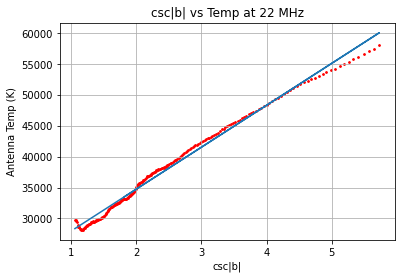

T_extra at 22MHz is 21145.32508
T_g at 22MHz is 6799.57492


100%|████████████████████████████████████████████████████████████████████████████████| 471/471 [00:00<00:00, 960.17it/s]


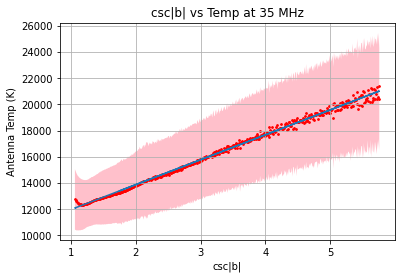

T_extra at 35MHz is 10082.98494
T_g at 35MHz is 1898.05314


100%|███████████████████████████████████████████████████████████████████████████████| 471/471 [00:00<00:00, 1050.82it/s]


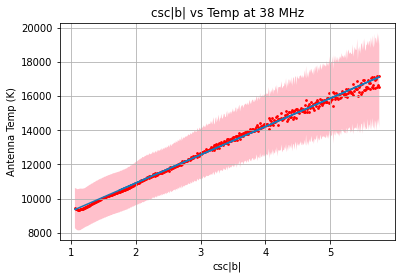

T_extra at 38MHz is 7607.22065
T_g at 38MHz is 1650.49483


100%|████████████████████████████████████████████████████████████████████████████████| 471/471 [00:00<00:00, 979.01it/s]


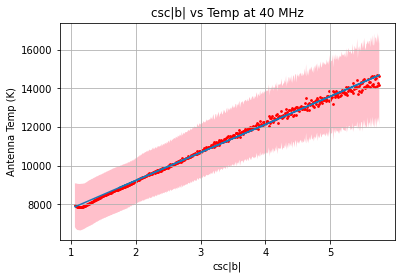

T_extra at 40MHz is 6334.79975
T_g at 40MHz is 1447.47503


100%|███████████████████████████████████████████████████████████████████████████████| 471/471 [00:00<00:00, 1081.78it/s]


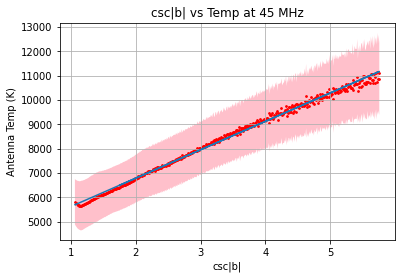

T_extra at 45MHz is 4457.25269
T_g at 45MHz is 1165.46361


100%|█████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 8818.74it/s]


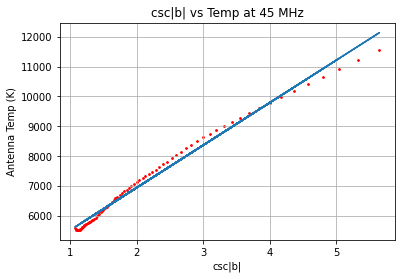

T_extra at 45MHz is 4111.04862
T_g at 45MHz is 1419.25352


100%|███████████████████████████████████████████████████████████████████████████████| 471/471 [00:00<00:00, 1043.60it/s]


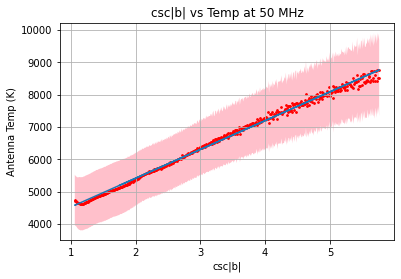

T_extra at 50MHz is 3638.10652
T_g at 50MHz is 889.79735


100%|███████████████████████████████████████████████████████████████████████████████| 471/471 [00:00<00:00, 1148.66it/s]


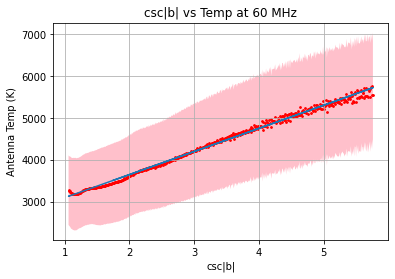

T_extra at 60MHz is 2553.54461
T_g at 60MHz is 551.12563


100%|███████████████████████████████████████████████████████████████████████████████| 471/471 [00:00<00:00, 1014.11it/s]


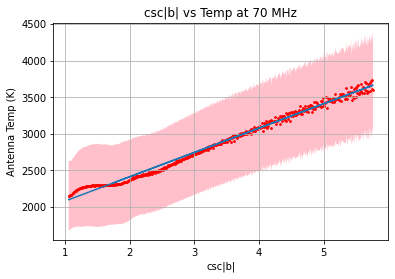

T_extra at 70MHz is 1746.95385
T_g at 70MHz is 333.02645


100%|████████████████████████████████████████████████████████████████████████████████| 471/471 [00:00<00:00, 960.75it/s]


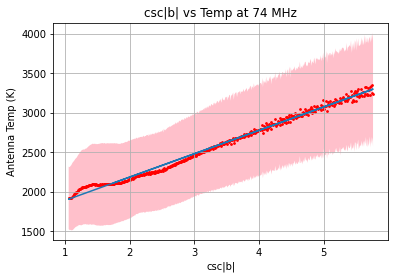

T_extra at 74MHz is 1594.08735
T_g at 74MHz is 296.40839


100%|███████████████████████████████████████████████████████████████████████████████| 471/471 [00:00<00:00, 1048.09it/s]


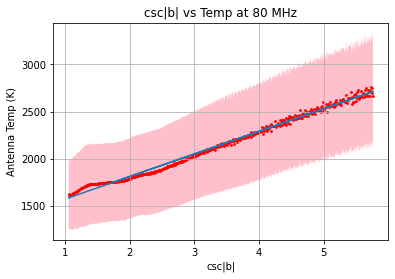

T_extra at 80MHz is 1332.42823
T_g at 80MHz is 239.52909


100%|████████████████████████████████████████████████████████████████████████████████| 315/315 [00:01<00:00, 258.78it/s]


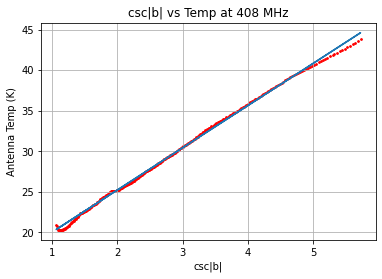

T_extra at 408MHz is 14.81542
T_g at 408MHz is 5.20061


100%|███████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 1528.53it/s]


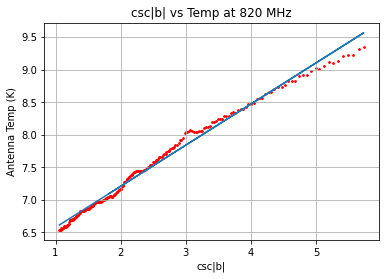

T_extra at 820MHz is 5.94290
T_g at 820MHz is 0.63253


100%|███████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 1038.64it/s]


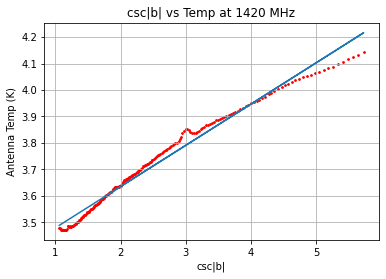

T_extra at 1420MHz is 3.32345
T_g at 1420MHz is 0.15580


100%|███████████████████████████████████████████████████████████████████████████████| 471/471 [00:00<00:00, 1628.82it/s]


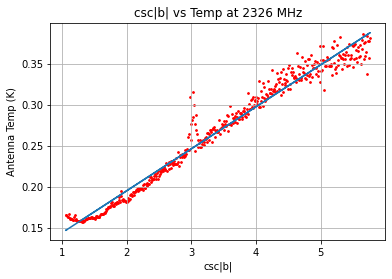

T_extra at 2326MHz is 0.09213
T_g at 2326MHz is 0.05130


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 30393.51it/s]


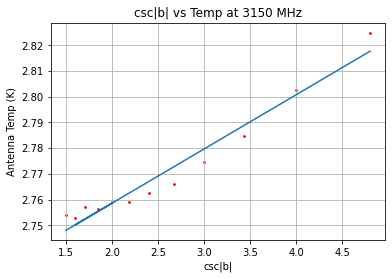

T_extra at 3150MHz is 2.71628
T_g at 3150MHz is 0.02114


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 35246.25it/s]


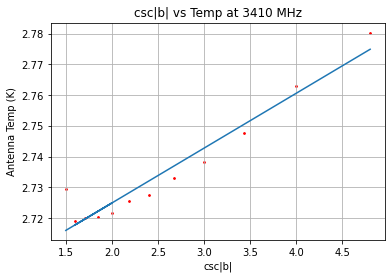

T_extra at 3410MHz is 2.68923
T_g at 3410MHz is 0.01785


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25510.21it/s]


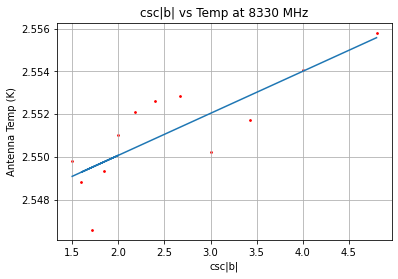

T_extra at 8330MHz is 2.54615
T_g at 8330MHz is 0.00196


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31928.96it/s]


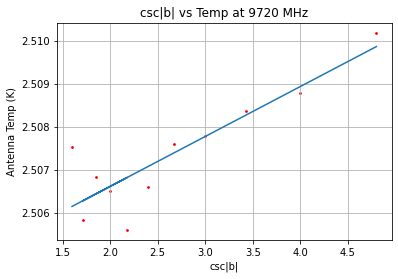

T_extra at 9720MHz is 2.50429
T_g at 9720MHz is 0.00116


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30313.63it/s]


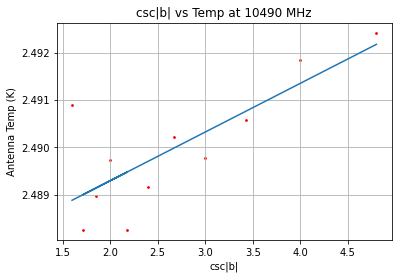

T_extra at 10490MHz is 2.48724
T_g at 10490MHz is 0.00103


In [178]:
c_array_hol_mean=[]
freq_hol_mean=[]
Temp_hol_mean=[]
Region="All"
for file in files:
    cscb_Temp_fit_hol_mean(file,Region)

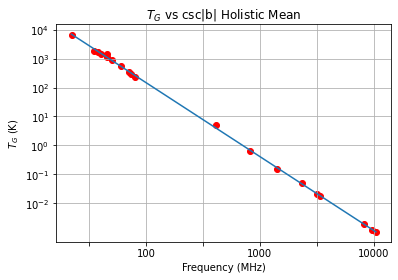

-2.550144494224397 7.265046394188443


In [179]:
FreqFit = np.log10(freq_hol_mean)
TempFit = np.log10(np.array(Temp_hol_mean))
a, b = np.polyfit(FreqFit,TempFit, 1)
plt.plot(FreqFit,a*FreqFit+b)
plt.grid()
plt.scatter(np.log10(freq_hol_mean),np.log10(Temp_hol_mean),color="red")
plt.yticks([-2,-1,0,1,2,3,4],["$10^{-2}$","$10^{-1}$","$10^0$","$10^1$","$10^2$","$10^3$","$10^4$"])
plt.xticks([1.5,2,2.5,3,3.5,4],["","100","","1000","","10000"])
plt.xlabel("Frequency (MHz)")
plt.ylabel("$T_G$ (K)")
plt.title("$T_G$ vs csc|b| Holistic Mean")
plt.show()
print(a,b)

# WIP:
- Now trying to plot extra-galactic graphs

In [181]:
c_array_hol_mean[-6]=c_array_hol_mean[-6]+2.725 #fix the 2326 map

In [182]:
TT=convert_to_TT(c_array_hol_mean,freq_hol_mean)

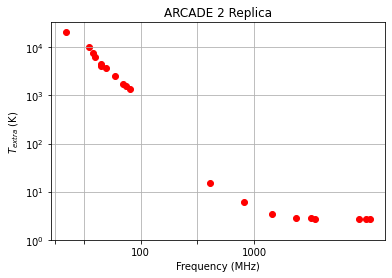

In [187]:
FreqFit = np.log10(freq_hol_mean)
TempFit = np.log10(np.array(TT))
a, b = np.polyfit(FreqFit,TempFit, 1)
plt.grid()
plt.scatter(np.log10(freq_hol_mean),np.log10(TT),color="red")
plt.yticks([0,1,2,3,4],["$10^0$","$10^1$","$10^2$","$10^3$","$10^4$"])
plt.xticks([1.25,1.5,2,2.5,3],["","","100","","1000"])
plt.xlabel("Frequency (MHz)")
plt.ylabel("$T_{extra}$ (K)")
plt.title("ARCADE 2 Replica")
plt.show()

In [184]:
#fitting
def func(freq,a,b,c):
    return np.log10(a+b*(freq/310)**(-c))

In [185]:
curve_fit(func,freq_hol_mean,np.log10(TT),p0=[2.725,10,2.5],bounds=(0,np.inf))

(array([ 2.69737617, 34.69873336,  2.5476001 ]),
 array([[ 2.37975075e-02, -1.54079529e-01,  2.37800222e-03],
        [-1.54079529e-01,  1.21511258e+01, -1.74775051e-01],
        [ 2.37800222e-03, -1.74775051e-01,  3.00550564e-03]]))